In [1]:
import numpy as np
import pandas as pd
from os import listdir
from numpy import genfromtxt

## Get data

In [2]:
studyname = 'UCR' 

In [3]:
def getdata(studyname,printfilenames):
    if studyname == 'Utrecht':
        #datadir = "/home/vincent/estep/data/utrecht"
        datadir = "/media/windows-share/utrecht_eeg"
        multivar = True #False # Are this Multivariate time series TRUE or FALSE
        labloc = "/home/vincent/estep/data/utrecht_labels.csv" # labels in column 1 (0), row 1 (1), or name of file
        timecol = True # time series per column (True) or per row (False)
    elif studyname == 'UCR':
        datadir = "/home/vincent/estep/data/UCR_TS_Archive_2015/50words"
        multivar = False # Are this Multivariate time series TRUE or FALSE
        labloc = 0 # Classifcation labels in column 1 (0), row 1 (1), seperate file (2)
        timecol = False # time series per column (True) or per row (False)
    else:
        raise ValueError(str(studyname) + ' is not a valid studyname')
    #============================================================================
    # Identify number of files and filetype based on datadir
    filenames = listdir(datadir)
    Nfiles = len(filenames) # number of files
    # Investigate what format the first file has by trying out a variety of reading attempts
    path = datadir + '/' + filenames[0]
    delimiter = [None,','] #possible delimiter values
    skiprows=[0,1]
    ntests = len(delimiter)*len(skiprows)
    df = pd.DataFrame(index=range(ntests),columns=['delimiter','skiprows','nrow','ncol','first cell'])
    cnt = 0
    for di in delimiter:
        for si in skiprows:
            try:
                F1 = np.loadtxt(fname=path,delimiter=di,skiprows=si)
                df['delimiter'][cnt] = di
                df['skiprows'][cnt] = si
                df['nrow'][cnt] = F1.shape[0]
                df['ncol'][cnt] = F1.shape[1]
                df['first cell'][cnt] = F1[0,1]
            except:
                df['delimiter'][cnt] = di
                df['skiprows'][cnt] = si
                df['nrow'][cnt] = 0
                df['ncol'][cnt] = 0
                df['first cell'][cnt] = 0
            cnt = cnt + 1
    # df is now a dataframe with information to help identify how the data should be loaded
    # load one file based on the extracted information on fileformat
    form = df[df.nrow == max(df.nrow)] # extraction procedure that resulted in the largest number of rows is the best
    if form.shape[0] > 1:
        form = df[df.ncol == max(df.ncol)] # extraction procedure that resulted in the largest number of columns
    if studyname == 'Utrecht':
        X = np.zeros((Nfiles,4000,form.ncol)) # hardcoded expected datadimensions
    else:
        if type(labloc) == int:
            #form.nrow
            X = np.zeros((0,form.ncol,1)) # hardcoded expected datadimensions
            if labloc == 0:
                #y = np.zeros((form.nrow,1))
                y = np.zeros((0,1))
            else: 
                y = np.zeros((form.ncol,1))
        else:
            X = np.zeros((0,form.ncol,1))
            y = np.zeros((form.ncol,1))
    filenamelist = list()
    print('processing files:')
    jj = 0
    j_rowused = 0
    j_fileused = 0
    while jj < Nfiles: #for jj in range(Nfiles)
        if printfilenames:
            print(filenames[jj],end=' ')
        path = datadir + '/' + filenames[jj]
        if (form['delimiter'] == ',').bool():
            F2 = np.loadtxt(fname=path,delimiter=',',skiprows=int(form['skiprows']))
        else:
            F2 = np.loadtxt(fname=path,delimiter=None,skiprows=int(form['skiprows']))
                
        # Modify F2 to meet expected dimantions:
        if studyname == 'Utrecht' and F2.shape[0] >= 4000:
            F2 = F2[0:4000,]
        elif studyname == 'Utrecht' and F2.shape[0] < 4000:
            jj += 1
            print(" NOT ENOUGH DATA")
            continue # we are not interested in files with less than 4000 values
        
        ## Extract label (y)
        labtype = 'int'
        if jj == 0 and studyname == 'Utrecht': #for Utrecht we only want to get the y once
            if type(labloc) == str:
                y = pd.read_csv(labloc, sep=',',header=0)
            elif type(labloc) == int:
                if labloc == 0:
                    y = np.array(F2[:,0], dtype=labtype)
                elif labloc == 1:
                    y = np.array(F2[0,:], dtype=labtype)
        else: # For UCR we want to get all y
            if type(labloc) == str:
                y = pd.read_csv(labloc, sep=',',header=0)
            elif type(labloc) == int:
                if labloc == 0:
                    tmpa = np.array(F2[:,0],dtype=labtype,ndmin=2).transpose()
                    y = np.vstack((y,tmpa))
                elif labloc == 1:
                    y = np.vstack((y,np.array(F2[0,:], dtype=labtype).transpose()))
        ## Extract data (X)
        if type(labloc) == str:
            if timecol == False:
                X[j_fileused,:,:] = F2.transpose()
            else:
                X[j_fileused,:,:] = F2    
        elif type(labloc) == int:
            if studyname == 'UCR':
                tmpp = np.reshape(F2,(F2.shape[0],F2.shape[1],1))
                X = np.vstack((X,tmpp))
                j_rowused += F2.shape[0]-1
            else:
                if labloc == 0:
                    X[j_fileused,:,:] = F2[:,1:]
                elif labloc == 1:
                    X[j_fileused,:,:] = F2[1:,:].transpose()
        ## Remember filenames
        if studyname == 'Utrecht':
            filenamelist.append(filenames[jj])
        else:
            filenamelist.append(filenames[jj])
        jj += 1
        j_rowused += 1
        j_fileused += 1
    return(X, y, filenamelist, Nfiles)

In [4]:
# get data
X, y, filenamelist, Nfiles = getdata(studyname,printfilenames=False)


/home/vincent/estep/.venv/lib/python3.4/site-packages/ipykernel/__main__.py:52: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


processing files:


In [5]:
print(X.shape, y.shape, len(filenamelist), Nfiles)

(905, 271, 1) (905, 1) 2 2


In [6]:
if studyname == 'Utrecht':
    y = y.as_matrix()
Xtrain = X[0:300,:,:]
ytrain = y[0:300,]
Xtest = X[301:,:,:]
ytest = y[301:,]

In [7]:
print(Xtrain.shape, ytrain.shape, Nfiles)
print(Xtest.shape, ytest.shape, Nfiles)

(300, 271, 1) (300, 1) 2
(604, 271, 1) (604, 1) 2


In [8]:
ytrain.shape

(300, 1)

In [9]:
# For Utrecht data we now need a conversion from y to a y that matches the X

# Design and compile some architectures

In [10]:
# Now, lets try to train some models
from keras.models import Sequential
from keras.layers import Merge, Dense, Dropout, Activation, LSTM
from keras.optimizers import SGD
import numpy as np
from keras.utils.np_utils import to_categorical

Using Theano backend.


In [14]:
timesteps = Xtrain.shape[1]
if studyname == 'UCR':
    data_dim = 1
    nb_classes = 51
else:
    data_dim = 21
    nb_classes = 2
X_train = Xtrain #np.random.random((100, timesteps))
y_train = ytrain #np.random.randint(nb_classes,size=(100,1))
X_test = Xtest #np.random.random((100, timesteps))
y_test = ytest #np.random.randint(nb_classes,size=(100,1))
y_train_original = y_train
y_test_original = y_test


In [15]:
y_train = to_categorical(np.squeeze(y_train))
y_test = to_categorical(np.squeeze(y_test))

/home/vincent/estep/.venv/lib/python3.4/site-packages/keras/utils/np_utils.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y = np.zeros((len(y), nb_classes))
/home/vincent/estep/.venv/lib/python3.4/site-packages/keras/utils/np_utils.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y[i, y[i]] = 1.


In [16]:
y_train.shape

(300, 51)

In [17]:
model = Sequential()
# Dense(64) is a fully-connected layer with 64 hidden units.
idim = timesteps
model.add(Dense(64, input_dim=idim, init='uniform'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64, init='uniform'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, init='uniform'))
model.add(Activation('softmax'))
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [18]:
X_train.shape

(300, 271, 1)

In [19]:
# reshape data, because LSTM requires different input format?
#X_train2 = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
#X_test2 = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [20]:
# let's try out another model
model2 = Sequential()
model2.add(LSTM(32, return_sequences=True,
               input_shape=(X_train.shape[1], X_train.shape[2])))  # returns a sequence of vectors of dimension 32
model2.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
model2.add(LSTM(32))  # return a single vector of dimension 32
model2.add(Dense(nb_classes, activation='softmax'))
model2.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Fit the architectures / models

In [21]:
#Fit model and store history of the fitting process
if studyname == 'UCR':
    X_train_tmp  = X_train
    X_train_tmp = np.reshape(X_train,(X_train.shape[0],X_train.shape[1]))
    History = model.fit(X_train_tmp, y_train,
              nb_epoch=5,batch_size=20,validation_split=0.2)
else:
    History = model.fit(X_train, y_train,
              nb_epoch=5,batch_size=20,validation_split=0.2)


Train on 240 samples, validate on 60 samples
Epoch 1/5
240/240 [==============================] - 0s - loss: 3.8605 - acc: 0.1167 - val_loss: 3.7225 - val_acc: 0.2333
Epoch 2/5
240/240 [==============================] - 0s - loss: 3.3107 - acc: 0.1833 - val_loss: 3.0582 - val_acc: 0.2667
Epoch 3/5
240/240 [==============================] - 0s - loss: 3.3311 - acc: 0.2042 - val_loss: 3.7447 - val_acc: 0.1833
Epoch 4/5
240/240 [==============================] - 0s - loss: 4.2249 - acc: 0.1958 - val_loss: 3.8650 - val_acc: 0.1833
Epoch 5/5
240/240 [==============================] - 0s - loss: 4.9344 - acc: 0.1375 - val_loss: 4.3264 - val_acc: 0.2000


In [22]:
#Fit model and store history of the fitting process
History2 = model2.fit(X_train, y_train,batch_size=20,
                      nb_epoch=5,verbose=True,validation_split=0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/5
240/240 [==============================] - 6s - loss: 3.8581 - acc: 0.0458 - val_loss: 3.8588 - val_acc: 0.1000
Epoch 2/5
240/240 [==============================] - 5s - loss: 3.6802 - acc: 0.1250 - val_loss: 3.8027 - val_acc: 0.1500
Epoch 3/5
240/240 [==============================] - 4s - loss: 3.5556 - acc: 0.1792 - val_loss: 3.7692 - val_acc: 0.1333
Epoch 4/5
240/240 [==============================] - 4s - loss: 3.4780 - acc: 0.1875 - val_loss: 3.7708 - val_acc: 0.1000
Epoch 5/5
240/240 [==============================] - 4s - loss: 3.3937 - acc: 0.2000 - val_loss: 3.7339 - val_acc: 0.1167


# Evaluate models on test set

In [23]:
X_test_tmp  = X_test
X_test_tmp = np.reshape(X_test,(X_test.shape[0],X_test.shape[1]))

score = model.evaluate(X_test_tmp, y_test, batch_size=20,verbose=False)
print('Model 1: ' + str(score))
score2 = model2.evaluate(X_test, y_test, batch_size=20,verbose=False)
print('Model 2: ' + str(score2))

Model 1: [5.2090520021931228, 0.21854304961416104]
Model 2: [3.4804083353636281, 0.1870860971066336]


In [24]:
classes = model.predict_classes(X_test_tmp, batch_size=20)
proba = model.predict_proba(X_test_tmp, batch_size=20)

classes2 = model2.predict_classes(X_test, batch_size=20)
proba2 = model2.predict_proba(X_test, batch_size=20)

604/604 [==============================] - 4s     


In [25]:
from sklearn import metrics
metrics.confusion_matrix(classes, y_test_original)

array([[73, 34,  6, ...,  1,  0,  1],
       [ 4, 23,  2, ...,  0,  0,  0],
       [ 1,  0, 25, ...,  0,  1,  0],
       ..., 
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [26]:
metrics.confusion_matrix(classes2, y_test_original)

array([[56, 13,  2, ...,  0,  0,  4],
       [14, 22,  1, ...,  0,  0,  0],
       [ 8, 22, 35, ...,  3,  5,  0],
       ..., 
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [27]:
print(np.hstack((proba2, np.vstack((classes, y_test_original)).transpose())))

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [ ]:
print(np.hstack((proba2, np.vstack((classes2, y_test_original)).transpose())))

# Plot training process

In [28]:
#set up conditions for plotting
import matplotlib.pyplot as plt
%matplotlib inline

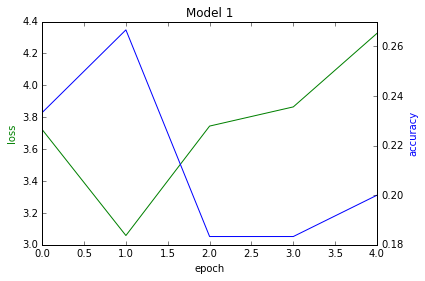

In [29]:
# plot loss and accuracy for model 2
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
LN = len(History.history['val_loss'])
ax1.plot(range(LN),History.history['val_loss'],'g-')
ax2.plot(range(LN),History.history['val_acc'],'b-')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss',color='g')
ax2.set_ylabel('accuracy',color='b')
plt.title('Model 1')

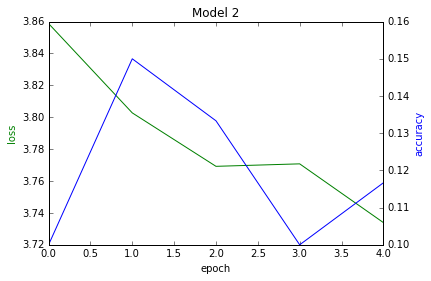

In [30]:
# plot loss and accuracy for model 2
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
LN = len(History2.history['val_loss'])
ax1.plot(range(LN),History2.history['val_loss'],'g-')
ax2.plot(range(LN),History2.history['val_acc'],'b-')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss',color='g')
ax2.set_ylabel('accuracy',color='b')
plt.title('Model 2')